In [ ]:
!pip install wandb bitsandbytes datasets transformers peft trl torch

In [ ]:
import os
import logging
import warnings
warnings.filterwarnings("ignore")

import wandb
import pandas as pd
from huggingface_hub import login
from transformers import (AutoModelForCausalLM, AutoTokenizer, 
                          BitsAndBytesConfig, TrainingArguments)
from datasets import load_dataset, concatenate_datasets
from peft import LoraConfig
from trl import SFTTrainer
import bitsandbytes as bnb
import torch

import config

# Environment Setup
login(token="hf_api_key", add_to_git_credential=True)

# set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def find_linear_layers(model):
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, bnb.nn.Linear4bit): 
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

def create_combined_text(record):
    instruction    = record['instruction'] if record['instruction'] is not None else ""
    input_text     = record['input'] if record['input'] is not None else ""
    out_text       = record['output'] if record['output'] is not None else ""
    
    if input_text is None or input_text == "":
      formatted_prompt = (
          f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n"
          f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:\n"
          f"<|eot_id|><|start_header_id|>asssitant<|end_header_id|>\n\n",
          f"{str(out_text)}"
          f"<|eot_id|><|end_of_text|>"
      )
    else:
      formatted_prompt = (
          f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n\n"
          f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Input:\n{input_text}\n\n### Response:\n"
          f"<|eot_id|><|start_header_id|>asssitant<|end_header_id|>\n\n"
          f"{str(out_text)}"
          f"<|eot_id|><|end_of_text|>"
      )
    formatted_prompt = "".join(formatted_prompt)
    return {'combined_text': formatted_prompt}

class TrainingPipeline:
    def __init__(self):
        self.datasets = {}
        self.model = None
        self.tokenizer = None
        self.final_dataset = None
        self.target_modules = []
        self.qlora_config = None

    def load_datasets(self):
        logging.info("Loading datasets...")

        self.datasets = {
            'dataset_1': load_dataset("json", data_files="/content/data/training_data.jsonl")
        }

        logging.info("Datasets loaded successfully!")

    def preprocess_datasets(self):
        logging.info("Preprocessing datasets...")
        concatenated_dataset = concatenate_datasets(
            [self.datasets['dataset_1']['train']])
        self.final_dataset = concatenated_dataset.map(create_combined_text)

        logging.info("Datasets preprocessed successfully!")

    def initialize_model_and_tokenizer(self):
        logging.info("Initializing model and tokenizer...")
        model_name = config.model_name
        bnb_config = BitsAndBytesConfig(
            #load_in_8bit = config.use_8bit,

            #4-bit quantize
            load_in_4bit = config.use_4bit,
            bnb_4bit_use_double_quant=config.use_nested_quant,
            bnb_4bit_quant_type=config.bnb_4bit_quant_type,
            bnb_4bit_compute_dtype=config.bnb_4bit_compute_dtype,
        )
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            #use_flash_attn=False,
            quantization_config=bnb_config,
            torch_dtype=torch.float16,
            trust_remote_code=True)

        self.model.config.use_cache = False
        self.model.config.pretraining_tp = 1
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=True)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        # Find linear layers and configure LoRA
        self.target_modules = find_linear_layers(self.model)
        if not self.target_modules:
            logging.error("No target modules found for LoRA. Check the model architecture.")
            return
        self.qlora_config = LoraConfig(
            r=config.lora_r,
            lora_alpha=config.lora_alpha,
            target_modules=self.target_modules,
            lora_dropout=config.lora_dropout,
            bias="none",
            task_type="CAUSAL_LM"
        )

    def train(self):
        logging.info("Starting training...")
        # Initialize Wandb
        wandb.login(key="4883f225eeb7f161f8ffe68ffff0d99b6337a47d")
        wandb.init(project="chuemjit-v1")

        # Training Configuration and Execution
        training_args = TrainingArguments(
            output_dir=config.output_dir,
            num_train_epochs=config.num_train_epochs,
            per_device_train_batch_size=config.per_device_train_batch_size,
            gradient_accumulation_steps=config.gradient_accumulation_steps,
            optim=config.optim,
            logging_steps=config.logging_steps,
            learning_rate=config.learning_rate,
            weight_decay=config.weight_decay,
            fp16=config.fp16,
            bf16=config.bf16,
            max_grad_norm=config.max_grad_norm,
            # max_steps=config.max_steps,
            warmup_ratio=config.warmup_ratio,
            group_by_length=config.group_by_length,
            lr_scheduler_type=config.lr_scheduler_type,
            save_total_limit=config.save_total_limit,
            # evaluation_strategy="no",
            save_strategy=config.save_strategy,
            report_to=config.report_to,
            # load_best_model_at_end=config.load_best_model_at_end,
            seed=config.seed,
            )
        trainer = SFTTrainer(
            model=self.model,
            train_dataset=self.final_dataset,
            args=training_args,
            tokenizer=self.tokenizer,
            peft_config=self.qlora_config,  
            dataset_text_field='combined_text',
            max_seq_length=config.max_seq_length,
            neftune_noise_alpha=config.neftune_noise_alpha,
        )
        trainer.train()

        logging.info("Training completed!")

        # Save the Model
        logging.info("Saving the model...")
        model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model
        model_to_save.save_pretrained(config.save_dir)
        logging.info("Saving completed!")

    def run_pipeline(self):
        self.load_datasets()
        self.preprocess_datasets()
        self.initialize_model_and_tokenizer()
        self.train()

In [ ]:
pipeline = TrainingPipeline()
pipeline.run_pipeline()

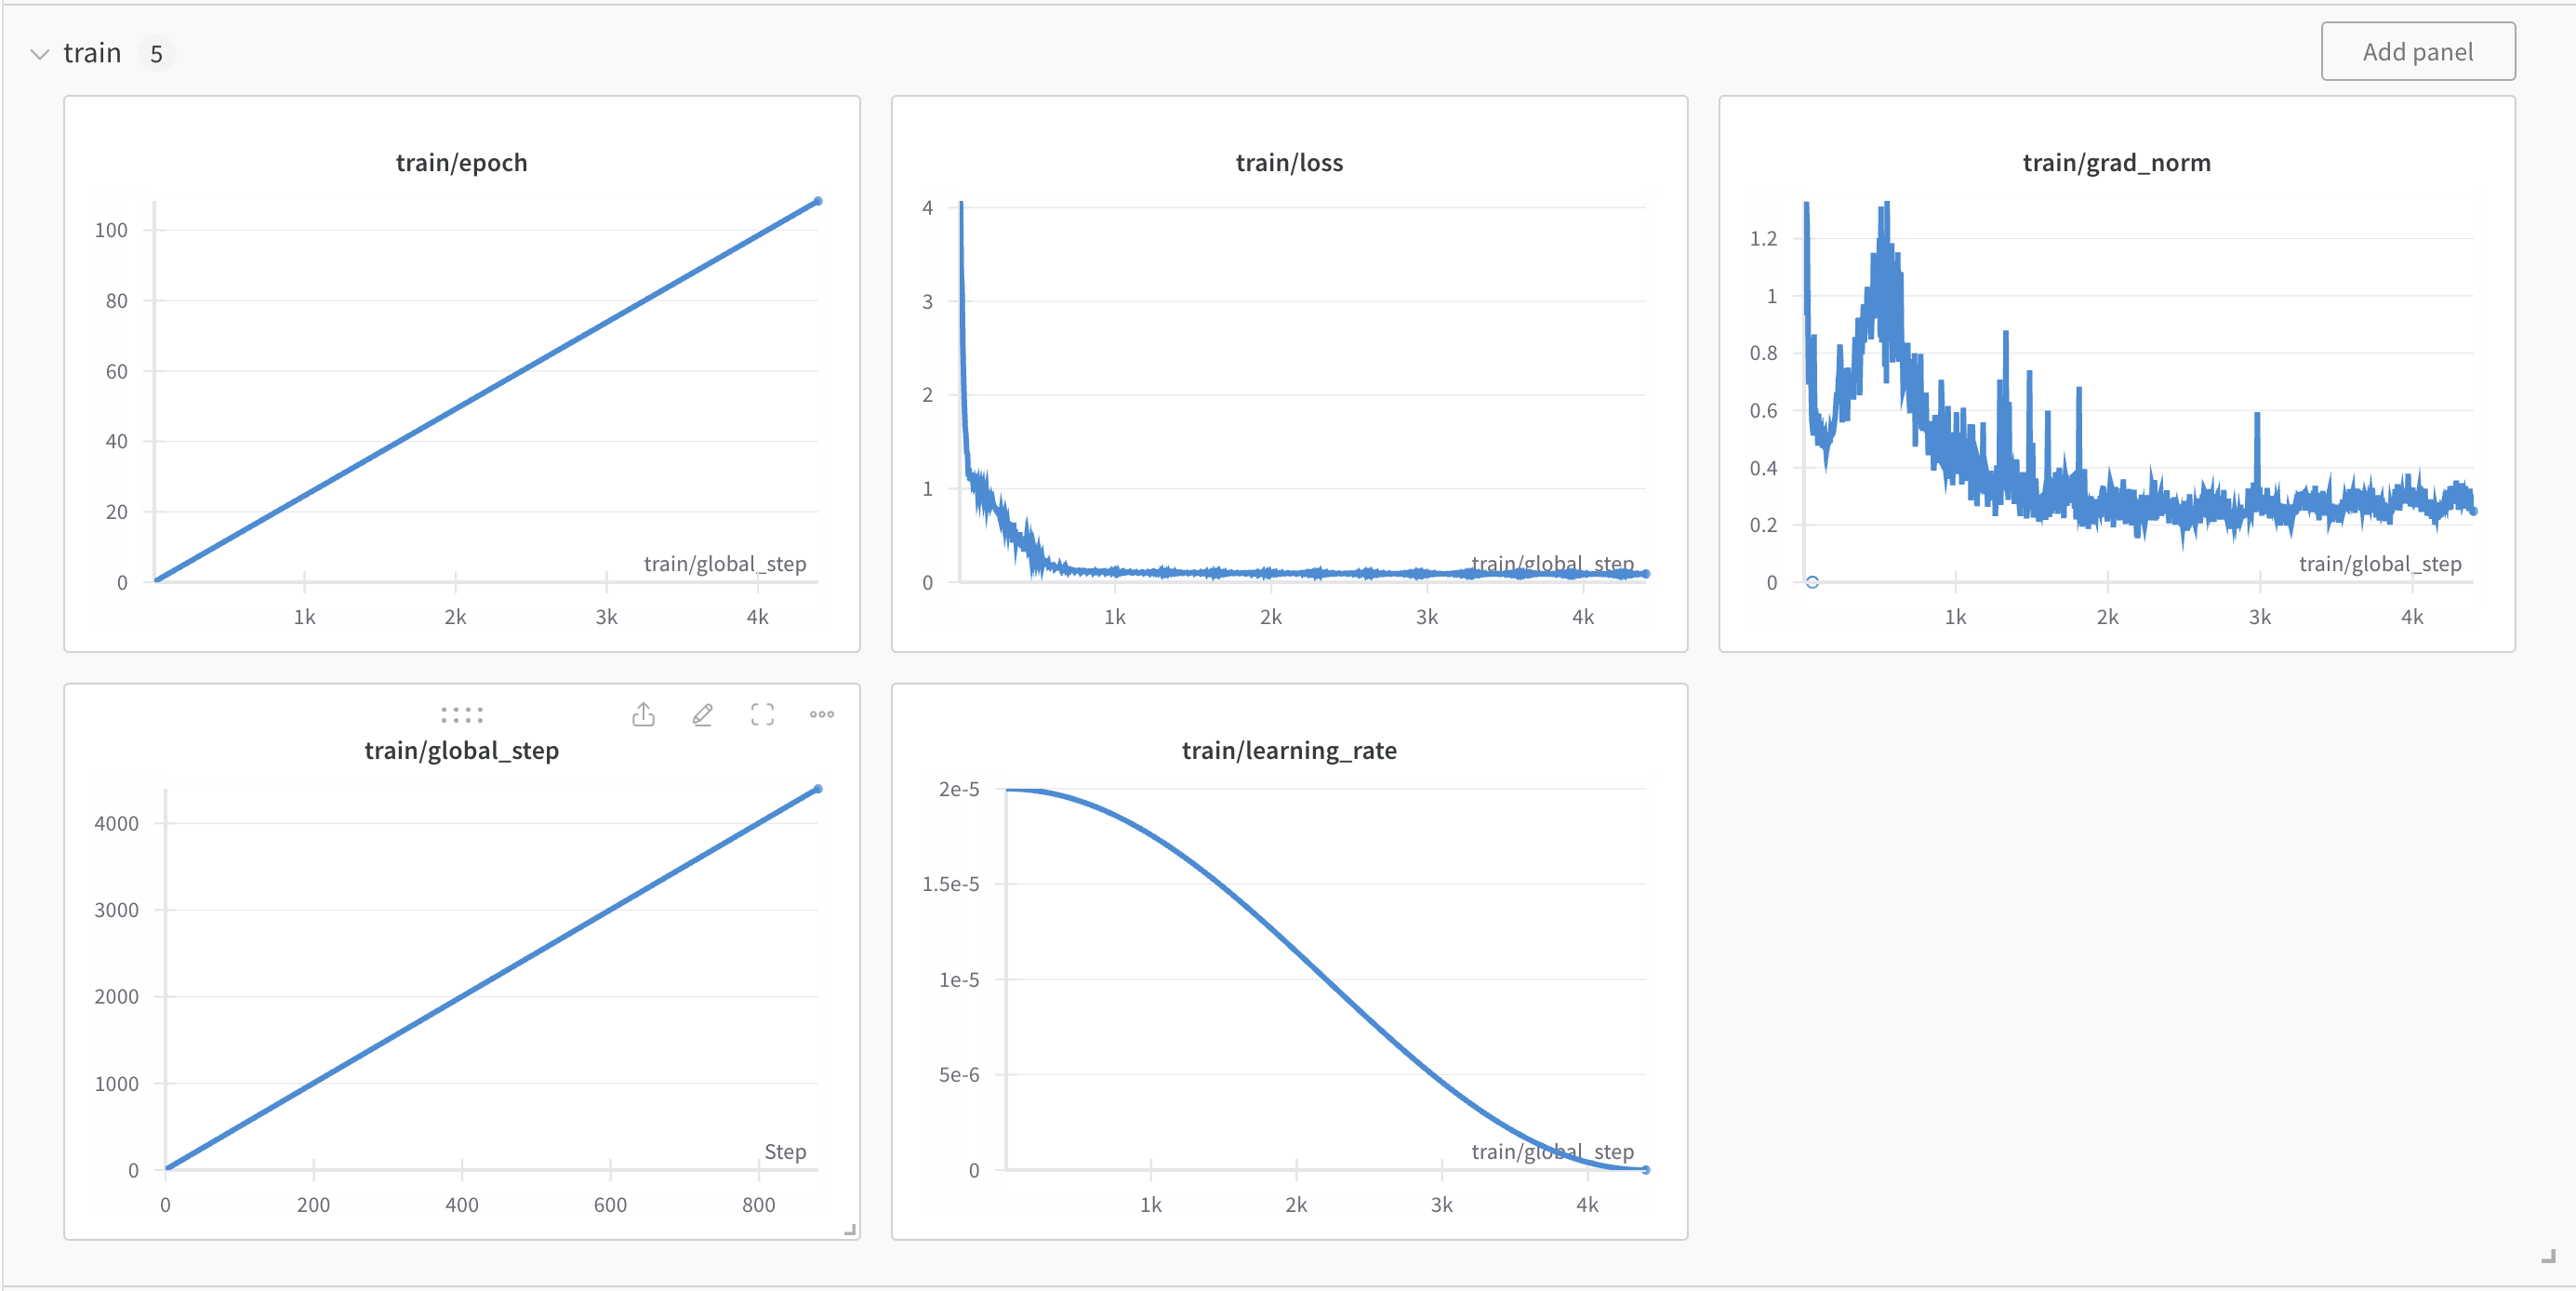